In [1]:
import kagglehub
dorianlazar_medium_articles_dataset_path = kagglehub.dataset_download('dorianlazar/medium-articles-dataset')

print('Data source import complete.')


100%|██████████| 1.33G/1.33G [00:18<00:00, 78.1MB/s]

Extracting files...


Data source import complete.


In [2]:
import pandas as pd
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import kagglehub

In [44]:
csv_file_path = os.path.join(dorianlazar_medium_articles_dataset_path, 'medium_data.csv')
medium_data = pd.read_csv(csv_file_path)
medium_data.head(15)

,id,url,title,subtitle,image,claps,responses,reading_time,publication,date
0,1,https://towardsdatascience.com/a-beginners-gui...,A Beginner’s Guide to Word Embedding with Gens...,NaN,1.png,850,8,8,Towards Data Science,2019-05-30
1,2,https://towardsdatascience.com/hands-on-graph-...,Hands-on Graph Neural Networks with PyTorch & ...,NaN,2.png,1100,11,9,Towards Data Science,2019-05-30
2,3,https://towardsdatascience.com/how-to-use-ggpl...,How to Use ggplot2 in Python,A Grammar of Graphics for Python,3.png,767,1,5,Towards Data Science,2019-05-30
3,4,https://towardsdatascience.com/databricks-how-...,Databricks: How to Save Files in CSV on Your L...,When I work on Python projects dealing…,4.jpeg,354,0,4,Towards Data Science,2019-05-30
4,5,https://towardsdatascience.com/a-step-by-step-...,A Step-by-Step Implementation of Gradient Desc...,One example of building neural…,5.jpeg,211,3,4,Towards Data Science,2019-05-30
5,6,https://towardsdatascience.com/an-easy-introdu...,An Easy Introduction to SQL for Data Scientists,NaN,6.jpeg,563,1,8,Towards Data Science,2019-05-30
6,7,https://towardsdatascience.com/hypothesis-test...,Hypothesis testing visualized,Literally seeing how stat tests work,7.gif,276,1,12,Towards Data Science,2019-05-30
7,8,https://towardsdatascience.com/introduction-to...,Introduction to Latent Matrix Factorization Re...,NaN,8.png,126,2,5,Towards Data Science,2019-05-30
8,9,https://towardsdatascience.com/which-2020-cand...,Which 2020 Candidate is the Best at Twitter?,A Data Analysis of the 2020 Democratic Candida...,9.png,188,3,8,Towards Data Science,2019-05-30
9,10,https://towardsdatascience.com/what-if-ai-mode...,What if AI model understanding were easy?,See analytics-for-AI in action in this What-I...,10.jpg,493,2,8,Towards Data Science,2019-05-30


In [4]:
print("Records Total: ", medium_data.shape[0])
print("Fields Total: ", medium_data.shape[1])

Records Total:  6508
Fields Total:  10


In [5]:
medium_data['title']

,title
0,A Beginner’s Guide to Word Embedding with Gens...
1,Hands-on Graph Neural Networks with PyTorch & ...
2,How to Use ggplot2 in Python
3,Databricks: How to Save Files in CSV on Your L...
4,A Step-by-Step Implementation of Gradient Desc...
...,...
6503,“We” vs “I” — How Should You Talk About Yourse...
6504,How Donald Trump Markets Himself
6505,Content and Marketing Beyond Mass Consumption
6506,5 Questions All Copywriters Should Ask Clients...


In [6]:
medium_data['title'] = medium_data['title'].apply(lambda x: x.replace(u'\xa0',u' '))
medium_data['title'] = medium_data['title'].apply(lambda x: x.replace('\u200a',' '))

In [7]:
tokenizer = Tokenizer(oov_token='<oov>')
tokenizer.fit_on_texts(medium_data['title'])
total_words = len(tokenizer.word_index) + 1

print("Total number of words: ", total_words)
print("<oov>: ", tokenizer.word_index['<oov>'])
print("Strong: ", tokenizer.word_index['strong'])
print("And: ", tokenizer.word_index['and'])
print("Consumption: ", tokenizer.word_index['consumption'])

Total number of words:  8238
<oov>:  1
Strong:  4
And:  8
Consumption:  8237


In [8]:
input_sequences = []
for line in medium_data['title']:
    token_list = tokenizer.texts_to_sequences([line])[0]

    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

print("Total input sequences: ", len(input_sequences))

Total input sequences:  48461


In [9]:
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
print(input_sequences)

[[  0   0   0 ...   0   5 676]
 [  0   0   0 ...   5 676  68]
 [  0   0   0 ... 676  68   2]
 ...
 [  0   0   0 ...   5  85  56]
 [  0   0   0 ...  85  56 730]
 [  0   0   0 ...  56 730 550]]


In [10]:
x = input_sequences[:,:-1]
labels=input_sequences[:,-1]
y = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [52]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add((LSTM(150)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x, y, epochs=50, verbose=1)
print(model)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 152s 99ms/step - accuracy: 0.0508 - loss: 7.3299
Epoch 2/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 200s 97ms/step - accuracy: 0.1297 - loss: 6.2792
Epoch 3/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 202s 97ms/step - accuracy: 0.1558 - loss: 5.7828
Epoch 4/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 200s 96ms/step - accuracy: 0.1848 - loss: 5.3153
Epoch 5/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 201s 95ms/step - accuracy: 0.2105 - loss: 4.8685
Epoch 6/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 201s 94ms/step - accuracy: 0.2347 - loss: 4.4654
Epoch 7/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 203s 95ms/step - accuracy: 0.2713 - loss: 4.0808
Epoch 8/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 203s 95ms/step - accuracy: 0.3152 - loss: 3.6933
Epoch 9/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 202s 95ms/step - accuracy: 0.3698 - loss: 3.3326
Epoch 10/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 202s 95ms/step - accuracy: 0.4214 - loss: 3.0095
Epoch 11/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 147s 97ms/step - accuracy: 0.4724 - loss: 2.72

In [53]:
print(model.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 39, 100)        │       823,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 150)            │       150,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8238)           │     1,243,938 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,655,016 (25.39 MB)

 Trainable params: 2,218,338 (8.46 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,436,678 (16.92 MB)

None


In [54]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

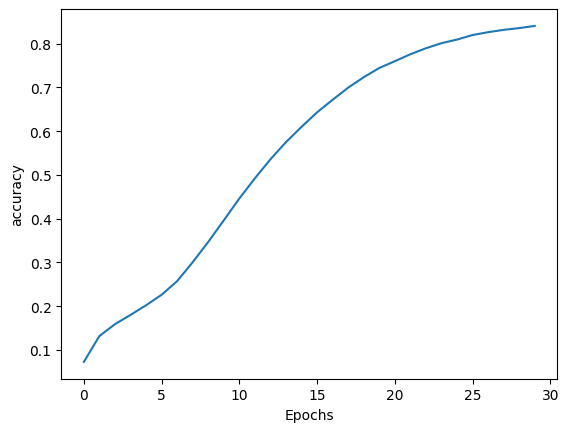

In [15]:
plot_graphs(history, 'accuracy')

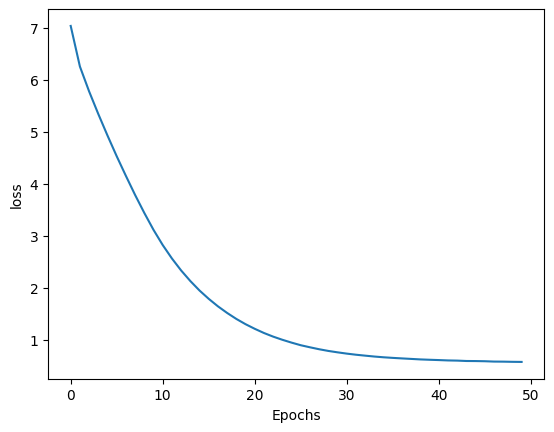

In [55]:
plot_graphs(history, 'loss')

In [56]:
import time
text = input("Enter a text: ")

for i in range(10):
  token_text = tokenizer.texts_to_sequences([text])[0]
  padded_token_text = pad_sequences([token_text], maxlen=56, padding='pre')
  pos = np.argmax(model.predict(padded_token_text))

  for word,index in tokenizer.word_index.items():
    if index == pos:
      text = text + " " + word
      print(text)
      time.sleep(2)

Enter a text: Content
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
Content and
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Content and marketing
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Content and marketing beyond
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Content and marketing beyond mass
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Content and marketing beyond mass consumption
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Content and marketing beyond mass consumption of
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Content and marketing beyond mass consumption of the
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Content and marketing beyond mass consumption of the other
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Content and marketing beyond mass consumption of the other method
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Content and marketing beyond mass consumption of the other method by


In [58]:
import numpy as np
from IPython.display import Audio
from google.colab import output

def speak(text):
  output.eval_js(f'new Audio("https://dict.youdao.com/dictvoice?audio={text}").play()')

text = input("Enter a text: ")

for i in range(9):
  token_text = tokenizer.texts_to_sequences([text])[0]
  padded_token_text = pad_sequences([token_text], maxlen=max_sequence_len-1, padding='pre')
  predicted_probabilities = model.predict(padded_token_text, verbose=0)[0]
  pos = np.argmax(predicted_probabilities)

  for word,index in tokenizer.word_index.items():
    if index == pos:
      text = text + " " + word
      print(text)
      speak(word)
      time.sleep(2)


Enter a text: Databricks
Databricks how
Databricks how to
Databricks how to save
Databricks how to save files
Databricks how to save files in
Databricks how to save files in csv
Databricks how to save files in csv on
Databricks how to save files in csv on your
Databricks how to save files in csv on your local
